### AAE and Auxiliary ELBO

In [1]:
import torch
import torchvision

from collections import defaultdict
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Upload filters

In [4]:
import pickle
path = os.path.join('drive', 'My Drive','conv1.pkl')
with open(path, 'rb') as handle:
    conv_1 = pickle.load(handle)

In [5]:
import pickle
path = os.path.join('drive', 'My Drive','conv_2.pkl')
with open(path, 'rb') as handle:
    conv_2 = pickle.load(handle)


In [6]:
import pickle
path = os.path.join('drive', 'My Drive','conv_3.pkl')
with open(path, 'rb') as handle:
    conv_3 = pickle.load(handle)

In [7]:
filters_1 = conv_1.reshape(20*16*3,3,3) 
filters_2 = conv_2.reshape(20*32*16,3,3)
filters_3 = conv_3.reshape(20*64*32,3,3)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

In [8]:
mask = [torch.linalg.norm(filters_1,dim=(-2,-1)) > 0.3][0]
filters_1 = filters_1[mask]

mask = [torch.linalg.norm(filters_2,dim=(-2,-1)) > 0.3][0]
filters_2 = filters_2[mask]

mask = [torch.linalg.norm(filters_3,dim=(-2,-1)) > 0.3][0]
filters_3 = filters_3[mask]

### AAE

In [9]:
class AdversarialEncoder(torch.nn.Module):
  def __init__(self, z_dim = 4, hidden_dim = 64):
    super().__init__()

    assert isinstance(z_dim, int)
    assert isinstance(hidden_dim,int)

    self.z_dim =z_dim
    self.hidden_dim = hidden_dim 

    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 1, out_channels = hidden_dim, kernel_size=(3,3),stride = (1,1),padding = 1 ,bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels= hidden_dim ,out_channels= hidden_dim ,kernel_size=(3,3),stride=(1,1),padding=1,bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels = hidden_dim, out_channels= 2*hidden_dim ,kernel_size=(2,2),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels= 2*hidden_dim,out_channels= 2*hidden_dim,kernel_size=(2,2),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),
        
    )
    ### torch.Size([batch, 128, 1, 1])
    ### without BatchNorm2d
    ### without Dropouts

    self.fc_linear = torch.nn.Linear(in_features = 2 * hidden_dim * 1 * 1, out_features = 2*z_dim  )



  def forward(self,input):
    input = self.features(input)
    ### torch.Size ([batch,128,1,1])
    input = input.view((-1, 2*self.hidden_dim*1*1))
    latent = self.fc_linear(input)
    mu_z, log_std_z = latent.chunk(2, dim = 1)

    return mu_z, log_std_z # [batch,4], [batch,4]

In [10]:
class Unflatten(torch.nn.Module):
  def __init__(self,shape):
    super().__init__()
    self.shape = shape
  
  def forward(self,input):
    return input.view(-1,self.shape[0],self.shape[1],self.shape[2])

In [11]:
class AdversarialDecoder(torch.nn.Module):
  def __init__(self,z_dim =4, hidden_dim = 64):
    super().__init__()

    self.z_dim = z_dim
    self.hidden_dim = hidden_dim

    self.fc_linear_unf = torch.nn.Sequential(
        torch.nn.Linear(in_features = z_dim , out_features = 2* hidden_dim * 1 * 1 ),
        Unflatten((2*hidden_dim,1,1)) )

    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 2*hidden_dim * 1 * 1, out_channels = 2*hidden_dim, kernel_size= (1,1), stride=(1,1),bias=False),
        #torch.nn.BatchNorm2d(2*hidden_dim),
        torch.nn.ELU(alpha=1.0),

        torch.nn.ConvTranspose2d(in_channels = 2*hidden_dim ,out_channels = hidden_dim, kernel_size =(3,3),stride=(1,1),bias=False ),
        #torch.nn.BatchNorm2d(hidden_dim),
        torch.nn.ELU(alpha=1.0),

        torch.nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(1,1),stride=(1,1),bias=False),
        torch.nn.ELU(alpha=1.0),


    )
    ## Tensor.Size([batch, hidden_dim, 3, 3])
    self.conva = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels = hidden_dim ,out_channels = 1 ,kernel_size = (1,1), stride = (1,1) ,bias=False)
    )
    ## Tensor.Size([batch,1,3,3])

    self.fc_lin = torch.nn.Linear(in_features = hidden_dim*3*3, out_features = 2*1*3*3)

  def forward(self,input):
    input = self.fc_linear_unf(input)
    input = self.features(input)
    reconstruction = self.conva(input)

    input = input.view(-1,self.hidden_dim*3*3)
    input = self.fc_lin(input)

    mu_x, log_std_x = input.chunk(2 , dim = 1)


    return mu_x,log_std_x,reconstruction # [batch,9], [batch,9], [batch,1,3,3]

In [12]:
class Discriminator(torch.nn.Module):
  def __init__(self,z_dim = 4,hidden_discr = 1000):
    super().__init__()

    assert isinstance(hidden_discr,int)

    self.z_dim = z_dim
    self.hidden_discr  = hidden_discr

    self.net = torch.nn.Sequential(
        torch.nn.Linear(in_features = z_dim, out_features = self.hidden_discr),
        torch.nn.LeakyReLU(0.2,inplace=True),
        torch.nn.Linear(in_features = self.hidden_discr, out_features = self.hidden_discr ),
        torch.nn.LeakyReLU(0.2, inplace=True),
        torch.nn.Linear(self.hidden_discr, 1),
        torch.nn.Sigmoid()
    )
  
  def forward(self,input):
    return self.net(input)

In [13]:
z_dim = 4
hidden_discr = 1000
encoder = AdversarialEncoder(z_dim,64)
decoder = AdversarialDecoder(z_dim,64)
discriminator = Discriminator(z_dim, hidden_discr)

In [14]:
minimax_lr = 1e-3
reconstruction_lr = 1e-3
EPS = 1e-15
EPOCHS = 4

In [15]:
encoder_optim = torch.optim.Adam(encoder.parameters(), lr = reconstruction_lr )
decoder_optim = torch.optim.Adam(decoder.parameters(), lr = reconstruction_lr)
generator_optim = torch.optim.Adam(encoder.parameters(), lr = minimax_lr)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr = minimax_lr )

In [26]:
def train_model(num_epochs, train_loader, encoder, decoder, discriminator ):

  reconstruction_loss = []
  generator_loss = []
  discriminator_loss = []

  encoder_optim = torch.optim.Adam(encoder.parameters(),lr= reconstruction_lr)
  generator_optim = torch.optim.Adam(encoder.parameters(),lr= minimax_lr)
  decoder_optim = torch.optim.Adam(decoder.parameters(),lr= reconstruction_lr)
  discriminator_optim = torch.optim.Adam(discriminator.parameters(),lr = minimax_lr)

  for epoch in range(num_epochs):
    
    encoder.train()
    decoder.train()
    discriminator.train()

    for data in tqdm_notebook(train_loader):
      
      encoder_optim.zero_grad()
      decoder_optim.zero_grad()
      discriminator_optim.zero_grad()
      generator_optim.zero_grad()

      ##### reconstruction loss #####
      mu_z, log_std_z = encoder(data)
      latent_sample = mu_z + log_std_z.exp()* torch.randn(data.shape[0],z_dim)
      # latent_sample.shape == torch.Size[Batch_size, z_dim = 4]
      
      #x_sample = decoder(latent_sample)[2]
      x_sample = mu_x + log_std_x.exp()*torch.randn(input.shape[0],3*3)
      x_sample = x_sample.view(-1,1,3,3)


      # x_sample.shape == torch.Size[Batch_size, 3, 32,32]
      # data.shape == torch.Size([Batch_size, 3, 32, 32])

      recon_loss = torch.nn.functional.mse_loss(x_sample,data,reduction='none')
      # recon_loss.shape == torch.Size([Batch_size,3,32,32])
      recon_loss = recon_loss.view(data.shape[0],-1).sum(1).mean()
      reconstruction_loss.append(recon_loss.item())
      recon_loss.backward()
      encoder_optim.step()
      decoder_optim.step()


      #### discriminator loss   #####

      encoder.eval()
      real_latent = torch.randn(data.shape[0],z_dim)
      # real_latent.shape == torch.Size([BATCH_SIZE,n_latent])
      real_discriminator = discriminator(real_latent)
      # real_discriminator.shape == torch.Size([Batch_Size,1])

      mu_fake, log_std_fake = encoder(data)
      fake_latent = mu_fake + log_std_fake.exp()*torch.randn(data.shape[0],z_dim)
      fake_discriminator = discriminator(fake_latent)
      #fake_discriminator.shape == torch.Size([Batch_size,1])
      
      discr_loss = -torch.mean(torch.log(real_discriminator + EPS) + torch.log( 1 - fake_discriminator + EPS))
      discriminator_loss.append(discr_loss)
      discr_loss.backward()
      discriminator_optim.step()
      

      ####   generator   loss   ####
      encoder.train()

      mu_z,log_std_z = encoder(data)
      fake_latent = mu_z + log_std_z.exp()*torch.randn(data.shape[0],z_dim)
      fake_discriminator = discriminator(fake_latent)

      gen_loss = -torch.mean(torch.log(fake_discriminator + EPS))
      generator_loss.append(gen_loss)
      gen_loss.backward()
      generator_optim.step()
      

  return reconstruction_loss, discriminator_loss, generator_loss

### AAE for filters 1

In [18]:
# Preparing data for training of filters_1
filters_1_data = filters_1.reshape(931,1,3,3)
filters_1_data_numpy = filters_1_data.numpy()

train_data = filters_1_data_numpy[:600].astype('float32')
test_data = filters_1_data_numpy[600:].astype('float32')

BATCH_FILTER_1 = 10

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_1,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_1)

In [19]:
reconstruction_loss, discriminator_loss, generator_loss =   train_model(EPOCHS,train_loader,encoder, decoder, discriminator )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


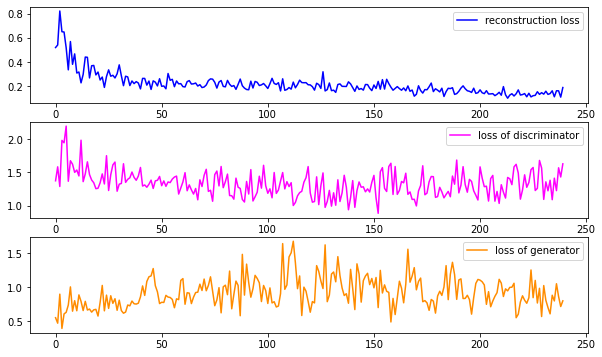

In [20]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(reconstruction_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discriminator_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(generator_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()


### AAE for filters 2

In [21]:
# Preparing data for training of filters_2
filters_2_data = filters_2.reshape(6783,1,3,3)
filters_2_data_numpy = filters_2_data.numpy()

train_data = filters_2_data_numpy[:5500].astype('float32')
test_data = filters_2_data_numpy[5500:].astype('float32')

BATCH_FILTER_2 = 25

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_2,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_2)

In [22]:
reconstruction_loss, discriminator_loss, generator_loss =   train_model(EPOCHS,train_loader,encoder, decoder, discriminator )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


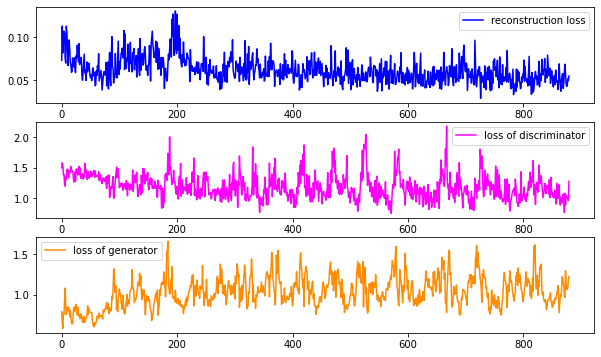

In [23]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(reconstruction_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discriminator_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(generator_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()

### AAE for filters 3

In [24]:

# Preparing data for training of filters_3
filters_3_data = filters_3.reshape(29083,1,3,3)
filters_3_data_numpy = filters_3_data.numpy()

train_data = filters_3_data_numpy[:25000].astype('float32')
test_data = filters_3_data_numpy[25000:].astype('float32')

BATCH_FILTER_3 = 50

train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_FILTER_3,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=BATCH_FILTER_3)

In [25]:
reconstruction_loss, discriminator_loss, generator_loss =   train_model(EPOCHS,train_loader,encoder, decoder, discriminator )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(reconstruction_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discriminator_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(generator_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()

As soon as we train AAE for filters of each layer  of CNN and having obtained parameters of distribution , one can move on to Auxiliary ELBO

### Auxiliary ELBO